# 0 Utils

In [1]:
import os
import numpy as np
import seaborn as sb
%matplotlib inline
sb.set()
import matplotlib.pyplot as plt
import pandas as pd
import shap


In [2]:
N_JOBS = -1
RANDOM_STATE = 42

## Experiment Setting 

In [3]:
import time
start_time = time.time()


In [4]:
predictors_set = dict()

no_is =['actividad', 'loc_comuna', 'loc_provincia', 'loc_region', 'is_descuento', 'is_presencial',
       'mean_cot_bod', 'mean_cot_depto', 'mean_cot_esta', 'mean_cot_estu', 'is_remoto',
       'nro_cot_bod', 'nro_cot_depto', 'valid_rut',
       'nro_cot_esta', 'nro_cot_estu', 'nro_proyectos','is_recontacto',
       'sexo', 'tipo_cliente', 'medio_inicial',  
        'Altos del Valle', 
        'Edificio Urban 1470',
       'San Andres Del Valle', 
        'Edificio Mil610', 
        'Edificio Junge'
       ]

predictors_set ['no_is'] = no_is

base = ['is_apellido1', 'is_appelido2', 'is_celular',
       'is_direccion', 'is_fnac', 'is_nombre', 'is_nombrecompleto',
       'is_nrofam', 'is_profesion', 'is_telefono',
       'loc_comuna', 'loc_provincia', 'loc_region',
       'mean_cot_bod', 'mean_cot_depto', 'mean_cot_esta', 'mean_cot_estu',
       'nro_cot_bod', 'nro_cot_depto',
       'nro_cot_esta', 'nro_cot_estu', 'nro_proyectos',
       'sexo', 'tipo_cliente', 
        'Altos del Valle', 
#         'Edificio Urban 1470',
       'San Andres Del Valle', 
        'Edificio Mil610', 
        'Edificio Junge']

print(len(base))
predictors_set ['base'] = base

base_profesion = base[0:]
base_profesion.append('profesion')
print(len(base_profesion))
predictors_set ['base_profesion'] = base_profesion

base_minusisprofesion = base_profesion[0:]
base_minusisprofesion.remove('is_profesion')
print(len(base_minusisprofesion))
predictors_set ['base_minusisprofesion'] = base_minusisprofesion

base_medini_isrec = base_profesion[0:]
base_medini_isrec.append('medio_inicial')
base_medini_isrec.append('is_recontacto')
print(len(base_medini_isrec))
predictors_set ['base_medini_isrec'] = base_medini_isrec


28
29
28
31


In [5]:
# dataset, base nro 2
dataset_nro = 7
experiment_nro = 1
# 'All Proyects', 'Altos del Valle', 'Edificio Urban 1470','San Andres Del Valle', 'Edificio Mil610', 'Edificio Junge'
proyecto_select = 'All Proyects'

# base, base_profesion, base_minusisprofesion, base_medini_isrec
use_predictors = 'no_is'
# experimento 2 y 4 va con True
no_nulls = False
sesgo = False

# 1 Load Dataset

In [6]:
# nombre experimento
exp_name = "{} {} exp".format(proyecto_select, use_predictors)
# eleccion dataset
dataset = 'personas_cotizacion{}.csv'.format(dataset_nro)

# DS_NAME = dataset.split('.')[0]
DS_NAME = exp_name

folder = '..\\results\\model_results\\{}'.format(DS_NAME)

if not os.path.exists(folder):
    os.mkdir(folder)


personas = pd.read_csv('..\\..\\Datos\\experiments\\{}'.format(dataset), encoding = "ISO-8859-1")

readme = dict()
readme['experiment_name'] = DS_NAME
readme['experiment_dataset'] = dataset

print(personas.shape)
readme['personas_shape'] = personas.shape
# personas.head(2)

print(personas.columns)
readme['personas_columns'] = personas.columns.tolist()

(6183, 42)
Index(['Unnamed: 0', 'actividad', 'compra', 'is_apellido1', 'is_apellido2',
       'is_celular', 'is_descuento', 'is_direccion', 'is_fnac', 'is_nombre',
       'is_nombrecompleto', 'is_nrofam', 'is_presencial', 'is_profesion',
       'is_recontacto', 'is_remoto', 'is_telefono', 'loc_comuna',
       'loc_provincia', 'loc_region', 'max_rango_edad', 'mean_cot_bod',
       'mean_cot_depto', 'mean_cot_esta', 'mean_cot_estu', 'medio_inicial',
       'negocio', 'nro_cot_bod', 'nro_cot_depto', 'nro_cot_esta',
       'nro_cot_estu', 'nro_proyectos', 'profesion', 'rut', 'sexo',
       'tipo_cliente', 'valid_rut', 'Altos del Valle', 'Edificio Urban 1470',
       'San Andres Del Valle', 'Edificio Mil610', 'Edificio Junge'],
      dtype='object')


In [7]:
personas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6183 entries, 0 to 6182
Data columns (total 42 columns):
Unnamed: 0              6183 non-null int64
actividad               6183 non-null object
compra                  6183 non-null bool
is_apellido1            6183 non-null bool
is_apellido2            6183 non-null bool
is_celular              6183 non-null bool
is_descuento            6183 non-null bool
is_direccion            6183 non-null bool
is_fnac                 6183 non-null bool
is_nombre               6183 non-null bool
is_nombrecompleto       6183 non-null bool
is_nrofam               6183 non-null bool
is_presencial           6183 non-null bool
is_profesion            6183 non-null bool
is_recontacto           6183 non-null bool
is_remoto               6183 non-null bool
is_telefono             6183 non-null bool
loc_comuna              6183 non-null object
loc_provincia           6183 non-null object
loc_region              6183 non-null object
max_rango_edad          

In [8]:
personas['loc_comuna'] = personas['loc_comuna'].astype('category')
personas['loc_provincia'] = personas['loc_provincia'].astype('category')
personas['loc_region'] = personas['loc_region'].astype('category')
personas['tipo_cliente'] = personas['tipo_cliente'].astype('category')
personas['sexo'] = personas['sexo'].astype('category')
personas.profesion.fillna('sin informacion', inplace=True)
personas['profesion'] = personas['profesion'].astype('category')
personas['medio_inicial'] = personas['medio_inicial'].astype('category')

In [9]:
personas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6183 entries, 0 to 6182
Data columns (total 42 columns):
Unnamed: 0              6183 non-null int64
actividad               6183 non-null object
compra                  6183 non-null bool
is_apellido1            6183 non-null bool
is_apellido2            6183 non-null bool
is_celular              6183 non-null bool
is_descuento            6183 non-null bool
is_direccion            6183 non-null bool
is_fnac                 6183 non-null bool
is_nombre               6183 non-null bool
is_nombrecompleto       6183 non-null bool
is_nrofam               6183 non-null bool
is_presencial           6183 non-null bool
is_profesion            6183 non-null bool
is_recontacto           6183 non-null bool
is_remoto               6183 non-null bool
is_telefono             6183 non-null bool
loc_comuna              6183 non-null category
loc_provincia           6183 non-null category
loc_region              6183 non-null category
max_rango_edad    

In [10]:
# personas['negocio'] = ['negocio' if x == True else 'no negocio' for x in personas.negocio]
# personas.negocio.unique()

In [11]:
# tab_info=pd.DataFrame(personas.dtypes).T.rename(index={0:'column type'})
# tab_info=tab_info.append(pd.DataFrame(personas.isnull().sum()).T.rename(index={0:'null values (nb)'}))
# tab_info=tab_info.append(pd.DataFrame(personas.isnull().sum()/personas.shape[0]*100).T.rename(index={0:'null values (%)'}))
# display(tab_info)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024CFD404A90>,
      dtype=object)

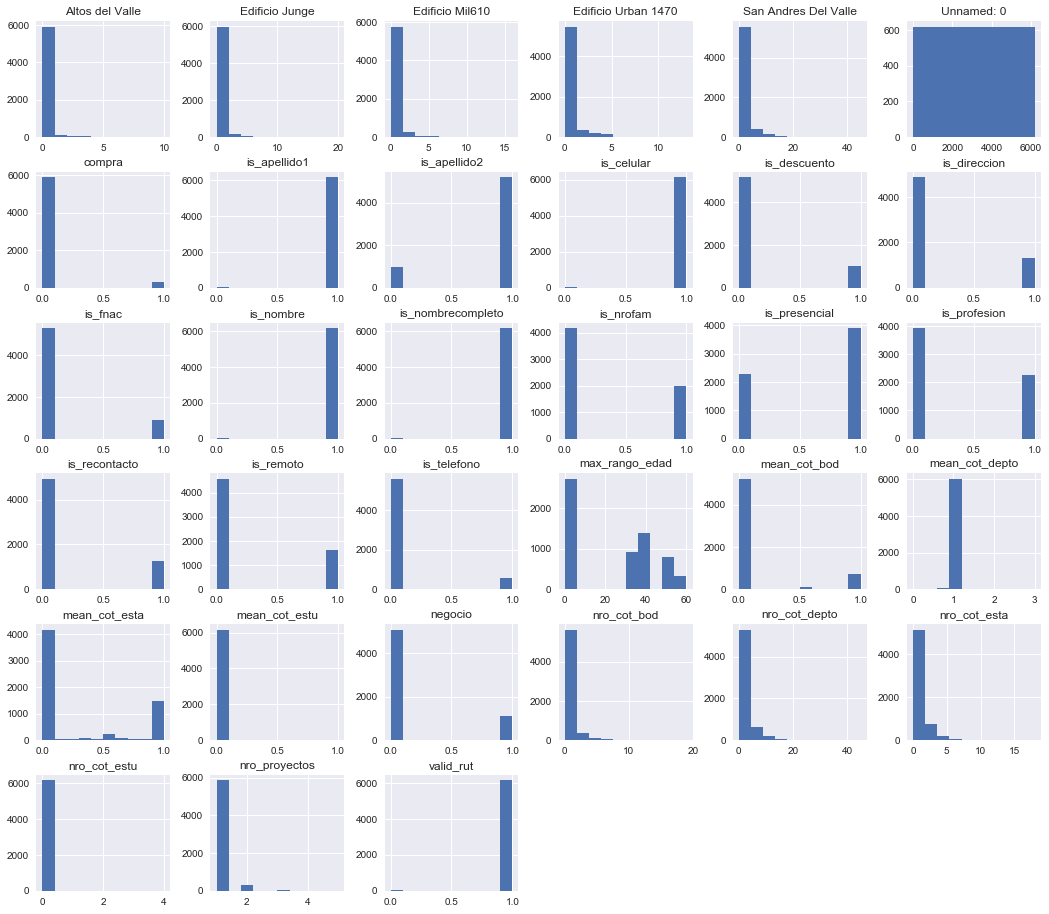

In [12]:
personas.hist(figsize=(18,16))

In [13]:
# Ajustes especificos experimento
# Para E5D5, E6D5 #########################################
if proyecto_select != 'All Proyects':
    mask = (personas[proyecto_select] > 0)
    personas = personas[mask]
    print(personas[mask].shape)
    personas[mask]
###########################################################

predictors = predictors_set[use_predictors]

# print(personas[personas['profesion']=='sin informacion'].shape)
# print(personas.profesion.nunique())
# print(personas.is_profesion.unique())

# En que experimento use esto? E8D6 y E28D6
# Se usa en los experimentos de data set limpio para evaluar con las personas que si entregaron la profesion
# personas.replace(['sin informacion'], np.nan, inplace=True)
# personas.dropna(inplace=True)
if no_nulls:
    personas.replace(['sin informacion'], np.nan, inplace=True)
    personas.dropna(inplace=True)

In [14]:
# Ready Data Set
p_negocio = personas.negocio # Target
# personas = personas.drop(drop_columns, axis=1) # Predictors
personas = personas[predictors]

print(p_negocio.shape)
print(personas.shape)
readme['personas_after_drop_columns'] = personas.columns

print(personas.shape)
readme['personas_predictors_shape'] = personas.shape
readme['personas_predictors'] = personas.columns


personas = pd.get_dummies(personas)
readme['personas_dummies_shape'] = personas.shape

# personas.describe()

(6183,)
(6183, 26)
(6183, 26)


## Correlacion 

In [15]:
# from scipy.stats.stats import pearsonr, spearmanr, kendalltau
# corr_p = personas.corr(method='pearson')

# import seaborn as sns
# f = plt.figure(figsize=(40,20))
# g = sns.heatmap(corr_p, annot=True).get_figure()
# g.savefig('..\\img\\time_series_corr.png')

In [16]:
# from sklearn.feature_selection import VarianceThreshold
# vt = VarianceThreshold()
# personas_vt = vt.fit_transform(personas)

In [17]:
# print(personas_vt.shape)
# print(vt.variances_)

# 3 Supervised Learning: Classification

## 3.1 Libraries

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

## 3.2 Check the Dataset

In [19]:
print("Tamaño Total: ", personas.shape)
print("Personas que hicieron Negocio: ", p_negocio[p_negocio == True].shape)
print("Personas que no Hicieorn Negocio: ", p_negocio[p_negocio == False].shape)
readme['personas_negocio'] = p_negocio[p_negocio == True].shape
readme['personas_nonegocio'] = p_negocio[p_negocio == False].shape

Tamaño Total:  (6183, 58)
Personas que hicieron Negocio:  (1100,)
Personas que no Hicieorn Negocio:  (5083,)


In [20]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2

# transformer = SelectKBest(score_func=chi2,k=10)
# Xt_chi2 = transformer.fit_transform(X,y)
# print(Xt_chi2.shape)
# print(transformer.scores_)

## 3.3 Train & Test

In [21]:
X = personas
y = p_negocio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
readme['x_train_shape'] = X_train.shape
readme['y_train_shape'] = y_train.shape
readme['x_test_shape'] = X_test.shape
readme['y_test_shape'] = y_test.shape

(4328, 58) (1855, 58) (4328,) (1855,)


## 3.4 Help Functions

In [22]:
readme['model'] = dict()

In [23]:
roc_curves_to_plot= dict()

In [24]:
roc_curves_to_plot[DS_NAME]= dict()

In [47]:
import json
def save_readme():    
    exDict = {'readme': readme}
    with open('..\\results\\model_results\\{}\\readme_{}.txt'.format(DS_NAME, DS_NAME), 'w') as file:
        file.write(str(exDict))

def plot_all_auc_values():
        
    d = dict()
    for key in roc_curves_to_plot[DS_NAME]:
        d[key] = roc_curves_to_plot[DS_NAME][key]['auc']
    
    s = [(k, d[k]) for k in sorted(d, key=d.get, reverse=True)]
    
    x_model = [x[0] for x in s]
    x_value = [x[1] for x in s]
    
    x = np.arange(len(roc_curves_to_plot[DS_NAME].keys()))
    
    plt.title('{} AUC Models'.format(DS_NAME))
    plt.xlabel('Models')
    plt.ylabel('AUC')
    plt.bar(x, x_value)
    plt.xticks(x, x_model)
    plt.savefig('..\\results\\model_results\\{}\\auc_models.png'.format(DS_NAME,DS_NAME), dpi=300)
    plt.show()

def plot_all_roc_curves():
    
    f = plt.figure(figsize=(12,8))
    plt.plot([0, 1], [0, 1], 'k--')
    
    for key in roc_curves_to_plot[DS_NAME]:
        plt.plot(roc_curves_to_plot[DS_NAME][key]['fpr'], roc_curves_to_plot[DS_NAME][key]['tpr']) #fpr and tpr
    
    legends = ['random choice']
    legends.extend(roc_curves_to_plot[DS_NAME].keys())
    plt.legend(legends)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Models ROC Curve'.format(DS_NAME))
    plt.savefig('..\\results\\model_results\\{}\\roc_curve_all.png'.format(DS_NAME, MODEL), dpi=300)
    plt.show()

# Import necessary modules
def roc_curve_plot(model, X_test, y_test):
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict_proba(X_test)[:,1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, treshold = roc_curve(y_test, y_pred_prob)
    
    roc_curves_to_plot[DS_NAME][MODEL] = dict()
    roc_curves_to_plot[DS_NAME][MODEL]['fpr'] = fpr
    roc_curves_to_plot[DS_NAME][MODEL]['tpr'] = tpr
    roc_curves_to_plot[DS_NAME][MODEL]['auc'] = roc_auc_score(y_test, y_pred_prob)
    
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} {} ROC Curve'.format(DS_NAME, MODEL))
    plt.savefig('..\\results\\model_results\\{}\\{}_roc_curve.png'.format(DS_NAME, MODEL), dpi=300)
    plt.show()

def plot_confusion_matrix(model, X, y, y_pred):
    conf_ma = confusion_matrix(y, y_pred)
    clas_report = classification_report(y, y_pred)
    
    print("Confusion Matrix: \n", conf_ma)
    readme['model'][MODEL]['conf_matrix'] = conf_ma
    
    print("Clasification Reports:\n",clas_report)
    readme['model'][MODEL]['cla_report'] = clas_report
    
    plt.figure(figsize=(5,5))
    
    sb.heatmap(conf_ma, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    title_plt = "{} {} Conf. Matrix".format(DS_NAME, MODEL)
    plt.title(title_plt, size=10);
    plt.savefig('..\\results\\model_results\\{}\\{}_confusion_matrix.png'.format(DS_NAME, MODEL), dpi=300)
    plt.show()

def plot_importance_graph(model):
    features = personas.columns
    
    feature_importance = model.best_estimator_.feature_importances_ 
    fig = plt.figure(figsize=(20, 18))
    ax = fig.add_subplot(111)

    df_f = pd.DataFrame(feature_importance, columns=["importance"])
    df_f["labels"] = features
    df_f.sort_values("importance", inplace=True, ascending=False)
    display(df_f.head(5))

    index = np.arange(len(feature_importance[:20]))
    bar_width = 0.5
    rects = plt.barh(index[:20] , df_f["importance"][:20], bar_width, alpha=0.4, color='b', label='Main')
    plt.yticks(index, df_f["labels"])
    plt.title("{} {} Feature Importance".format(DS_NAME, MODEL))
    plt.savefig('..\\results\\model_results\\{}\\{}_importance.png'.format(DS_NAME, MODEL), dpi=300)
    plt.show()

def grid_results(grid, plot_roc_curve=True):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

    best_model = grid.best_estimator_
    best_score = grid.best_score
    
    readme['model'][MODEL]['name'] = MODEL
    readme['model'][MODEL]['best_estimator'] = best_model
    readme['model'][MODEL]['best_score'] = best_score
    
    print("Best score is {}".format(grid.best_score_))
    
    y_pred = best_model.predict(X_test)
    
    # Confusion Matrix
    plot_confusion_matrix(best_model, X_test, y_test, y_pred)
    
    #Update Exec Time
    readme['time_exec'] = time.time() - start_time
    
    #Update README
    save_readme()
    
    #ROC Curve
    if plot_roc_curve:
        roc_curve_plot(best_model, X_test, y_test)

## 3.5 Models

In [39]:
to_profit_curve = dict()

Accuracy: 0.798921832884097
Confusion Matrix: 
 [[1216  281]
 [  92  266]]
Clasification Reports:
              precision    recall  f1-score   support

      False       0.93      0.81      0.87      1497
       True       0.49      0.74      0.59       358

avg / total       0.84      0.80      0.81      1855



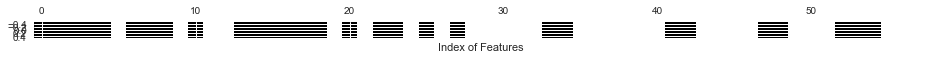

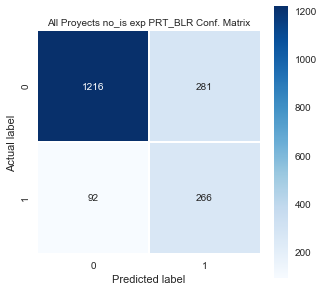

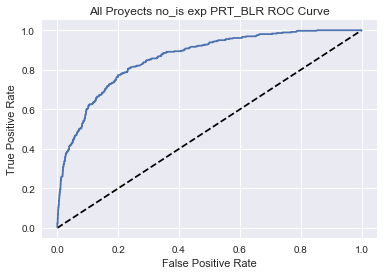

In [45]:
MODEL = 'PRT_BLR'
readme['model'][MODEL] = dict()

to_profit_curve[MODEL] = dict()

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=12, max_features=13,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=RANDOM_STATE,
            verbose=0, warm_start=False)

select = SelectFromModel(rf, threshold='median')

select.fit(X_train, y_train)
X_train_s = select.transform(X_train)

mask = select.get_support()
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel('Index of Features')

X_test_s = select.transform(X_test)

log_clf = LogisticRegression(C=0.4393970560760795, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=RANDOM_STATE,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

to_profit_curve[MODEL]['model'] = log
log_clf.fit(X_train_s, y_train)

score = log_clf.score(X_test_s, y_test)
print('Accuracy:', score)

plot_confusion_matrix(log_clf, X_test_s, y_test, log.predict(X_test_s))
roc_curve_plot(log_clf, X_test_s, y_test)

In [28]:
test_c = X_test.copy()
print(test_c.shape[0])
print(log.predict(X_test_s).shape[0])
test_c['pred'] = log.predict(X_test_s)
test_c['negocio'] = p_negocio
total_neg = test_c[test_c['negocio']==True].shape[0]
total_noneg = test_c[test_c['negocio']==False].shape[0]
print(total_neg)
print(total_noneg)

1855
1855
358
1497


In [29]:
un = test_c.nro_cot_depto.unique().tolist()
un_sorted = sorted(un)
percentage_pob = []
total_pob = []
for u in un_sorted:
    # total de personas que cotizaron u veces
    c = test_c[(test_c['nro_cot_depto'] == u)]['negocio'].sum()
    #total de personas que hicieron negocio
    d = test_c[(test_c['negocio']== True) & (test_c['nro_cot_depto']== u)]['negocio'].sum()
    total_pob.append(c)
    print(d/total_neg*100)
    percentage_pob.append(d/total_neg*100)

1.1173184357541899
12.011173184357542
18.71508379888268
13.128491620111731
13.40782122905028
8.659217877094973
8.379888268156424
5.58659217877095
6.145251396648044
3.35195530726257
1.9553072625698324
1.9553072625698324
0.8379888268156425
0.8379888268156425
1.3966480446927374
0.27932960893854747
0.5586592178770949
0.27932960893854747
0.5586592178770949
0.0
0.27932960893854747
0.27932960893854747
0.27932960893854747


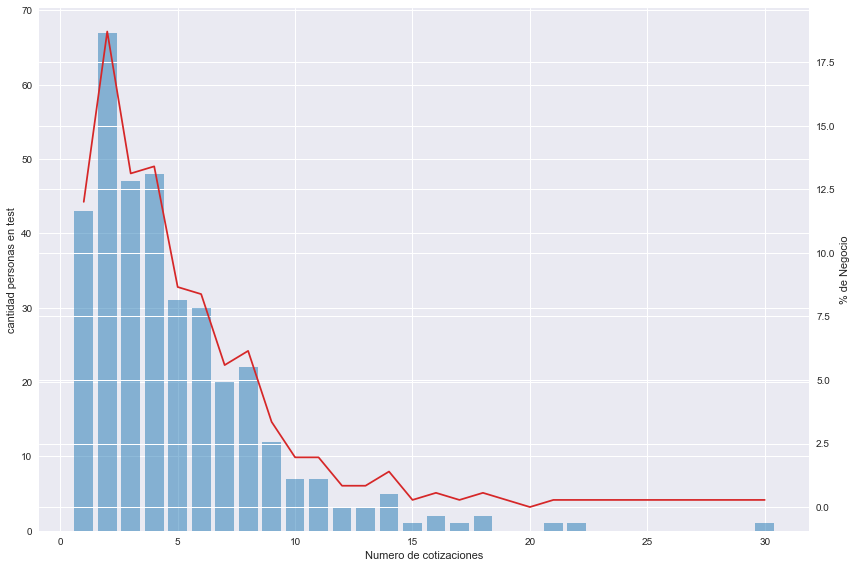

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
# t = np.arange(0.01, 10.0, 0.01)
# data1 = np.exp(t)
# data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots(figsize=(12,8))

color = 'tab:blue'
ax1.set_xlabel('Numero de cotizaciones')
ax1.set_ylabel('cantidad personas en test')
# ax1.plot(t, data1, color=color)
ax1.bar(un_sorted[1:], total_pob[1:], align='center', alpha=0.5, color=color)
# ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('% de Negocio')  # we already handled the x-label with ax1
ax2.plot(un_sorted[1:], percentage_pob[1:], color=color)
# ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [31]:
# f, ax1 = plt.subplot()
# ax1.bar(un_sorted[1:], total_pob[1:], align='center', alpha=0.5)
# ax2.plot(un_sorted[1:], percentage_pob[1:])
# plt.show()

In [32]:
log.fit(X_train_s, y_train)
# y_pred = log.predict(X_test_s)

# log.fit(X_train_s, y_train)
# predict = model.predict(X_test_s)
predict_probabilities = log.predict_proba(X_test_s)[:,1]


fpr, tpr, _ = roc_curve(y_test, predict_probabilities)

predict_mine = np.where(predict_probabilities > 0.3, 1, 0)
confusion_matrix(y_test, predict_mine)

array([[924, 573],
       [ 39, 319]], dtype=int64)

In [33]:
probs = log.predict_proba(X_test_s)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)

roc_auc = metrics.auc(fpr, tpr)

bla = dict()
bla['fpr'] = fpr
bla['tpr'] = tpr

bla['threshold'] = threshold
# bla
col = ['fpr', 'tpr', 'threshold']
df = pd.DataFrame.from_records(bla, columns=col)
# print(df.head())
# print(df.tail(30))

In [34]:
# import matplotlib.pyplot as plt
# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

# KNeighbors

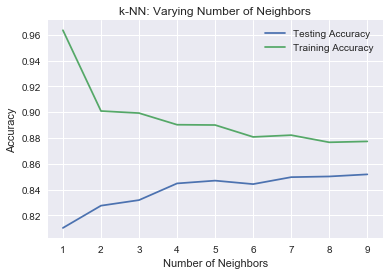

In [35]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 10)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=N_JOBS)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()


# KNeighbors

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')
           
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [46]:
MODEL = 'KNN'
readme['model'][MODEL] = dict()
from sklearn.metrics import mean_squared_error
X = MinMaxScaler().fit_transform(X)

# Instantiate a k-NN classifier: knn
knn_clf = KNeighborsClassifier()

# Param Grid
param_grid = {'n_neighbors': np.arange(1, 20)}

# Stratified
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# GridSearch
grid_knn = GridSearchCV(knn_clf, param_grid, cv=kf, n_jobs=N_JOBS)
grid_knn.fit(X,y)

# grid_results(grid_knn)

Best Params:  {'n_neighbors': 13}
Best Estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=13, p=2,
           weights='uniform')


AttributeError: 'GridSearchCV' object has no attribute 'metrics'

In [54]:
print(type(grid_knn.scorer_))

<class 'function'>


In [38]:
best_knn = grid_knn.best_estimator_
best_knn.fit(X_train, y_train)
best_knn.score(X_test, y_test)

0.8506738544474394

# PCA + KNN

TN -> 81:
[('pca', PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)),
('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
metric_params=None, n_jobs=1, n_neighbors=5, p=2, weights='uniform'))]

In [ ]:
MODEL = 'PCAKNN'
readme['model'][MODEL] = dict()
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import LinearSVC 

pipe = Pipeline([
    ('pca', PCA()),
    ('clf', KNeighborsClassifier()),
])

parameters = {
    'pca__n_components': [2, 3, 4, 5, 6, 7, 8, 9],
#     'clf__C': [1, 20],
    }

from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_knnpca = GridSearchCV(pipe, parameters, cv=kf, n_jobs=N_JOBS, verbose=1)
grid_knnpca.fit(X, y)

best_parameters = grid_knnpca.best_estimator_.get_params()
print("Best parameters set: ", best_parameters)
print('Best Estimator: ', grid_knnpca.best_estimator_)
    
    
grid_results(grid_knnpca)
# print("Best score: %0.3f" % gs.best_score_)


# y_pred = gs.predict(X_test) 
# # results(y_pred, y)

# plot_confusion_matrix(gs,X_test,y_test,y_pred)
# roc_curve_plot(gs, X_test, y_test)

# LogisticRegression Grid

In [ ]:
X = MinMaxScaler().fit_transform(X)

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
C = np.logspace(0, 4, 10)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}


# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(class_weight=None)
# logreg = LogisticRegression()

# Stratified
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Instantiate the GridSearchCV object: logreg_cv
grid_logreg = GridSearchCV(logreg, param_grid, cv=kf, n_jobs=N_JOBS)
grid_logreg.fit(X, y)

# # Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print('Best Estimator: ', logreg_cv.best_estimator_)
# print("Best score is {}".format(logreg_cv.best_score_))
# Fit it to the data
grid_results(logreg_cv)
# # 
y_pred_prob = logreg_cv.predict_proba(X_test)[:,1]

print("ROC AUC Score:" ,roc_auc_score(y_test,y_pred_prob))

## LOGISTIC REGRESSION Unbalanced

In [ ]:
MODEL = 'ULR'
readme['model'][MODEL] = dict()
to_profit_curve[MODEL] = dict()

# Balanced Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

model = LogisticRegression(C=3.727593720314938, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=RANDOM_STATE,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

to_profit_curve[MODEL]['model'] = model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(model.score(X_test, y_test))
plot_confusion_matrix(model, X_test, y_test, y_pred)

#ROC Curve
roc_curve_plot(model, X_test, y_test)

## LOGISTIC REGRESSION Balanced

In [ ]:
MODEL = 'BLR'
readme['model'][MODEL] = dict()
to_profit_curve[MODEL] = dict()

# Balanced Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

model = LogisticRegression(C=3.727593720314938, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=RANDOM_STATE,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

to_profit_curve[MODEL]['model'] = model

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Model Score:", model.score(X_test, y_test))
plot_confusion_matrix(model, X_test, y_test, y_pred)

#ROC Curve
roc_curve_plot(model, X_test, y_test)

# DecisionTree GRID

In [ ]:
MODEL = 'UDT'
readme['model'][MODEL] = dict()
to_profit_curve[MODEL] = dict()
# Setup the parameters and distributions to sample from: param_dist

param_dist = {
    "max_depth": [3, 5, 10, 15, 20, None],
    "max_features": randint(1, 30),
    "min_samples_leaf": randint(1, 9),
    "criterion": ["gini", "entropy"]
}

param_dist = {
    "max_depth": range(1,20),
    "max_features":range(1,30),
    "min_samples_leaf": range(1,10),
    "criterion": ["gini", "entropy"]
}

# Instantiate a Decision Tree classifier: tree
# tree = DecisionTreeClassifier(class_weight='balanced')
tree_clf = DecisionTreeClassifier()

# Stratified
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Instantiate the RandomizedSearchCV object: tree_cv
# tree_cv = RandomizedSearchCV(tree, param_dist, cv=kf)
grid_tree = GridSearchCV(tree_clf, param_dist, cv=kf, n_jobs=N_JOBS)

to_profit_curve[MODEL]['model'] = grid_tree
# Fit it to the data
grid_tree.fit(X,y)

# # Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(grid_tree.best_params_))
print("Best score is {}".format(grid_tree.best_score_))
print("Best estimator is {}".format(grid_tree.best_estimator_))

grid_results(grid_tree)

In [ ]:
plot_importance_graph(tree_cv)

In [ ]:
best_dt = tree_cv.best_estimator_

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os, sys

def conda_fix(graph):
        path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")
        paths = ("dot", "twopi", "neato", "circo", "fdp")
        paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
        graph.set_graphviz_executables(paths)

# visualize the decision tree
dot_data = StringIO()
export_graphviz(best_dt, out_file=dot_data, feature_names=personas.columns, filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
conda_fix(graph)
# graph.write_pdf("booking_tree.pdf")
Image(graph.create_png())

In [ ]:
graph.write_pdf("..\\results\\model_results\\{}\\{}_decision_tree.pdf".format(DS_NAME,MODEL))

In [ ]:
bdt_clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=7,
            max_features=26, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=RANDOM_STATE,
            splitter='best')

from sklearn.model_selection import cross_val_predict
predictions = cross_val_predict(bdt_clf, X, y)

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)
plt.show()

bdt_clf.fit(X_train, y_train)
y_probas = bdt_clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()


# GRID Unbalanced RandomForest

In [ ]:
# Setup the parameters and distributions to sample from: param_dist
MODEL = 'URF'
readme['model'][MODEL] = dict()

param_grid = {
    "max_depth": randint(1,30),
    "max_features":randint(1,40),
    "min_samples_leaf": randint(1,20),
    "criterion": ["gini", "entropy"],
    "min_samples_split": randint(2,20),
    "n_estimators":[20,30,40,50,60,70,80,90,100],
    "bootstrap": [True, False],
}

param_grid = {"max_depth": list(range(1,30)),
              'max_features': ['auto', 'sqrt', 'log2'],
#               "max_features":range(1,40),
              "min_samples_split": list(range(2,30)),
              "min_samples_leaf": list(range(1,20)),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
             "n_estimators":list(range(20,100,10)),
#               "class_weight":[None,'balanced' ],
}

# Instantiate a Decision Tree classifier: tree
rf = RandomForestClassifier()

# Stratified
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Instantiate the RandomizedSearchCV object: tree_cv
rf_cv = RandomizedSearchCV(rf, param_dist, cv=kf, n_jobs=N_JOBS, n_iter=300)
# rf_cv = GridSearchCV(rf, param_grid, cv=kf, n_jobs=N_JOBS)

# Fit it to the data
rf_cv.fit(X,y)

# Predict
# y_pred = rf_cv.predict(X_test)

# Print the tuned parameters and score
print("Best estimator is {}".format(rf_cv.best_estimator_))
print("Tuned Decision Tree Parameters: {}".format(rf_cv.best_params_))
print("Best score is {}".format(rf_cv.best_score_))

grid_results(rf_cv)
plot_importance_graph(rf_cv)

# Unbalanced RandomForest

In [ ]:
bdt_clf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=26,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=False, random_state=RANDOM_STATE, verbose=0,
            warm_start=False)

from sklearn.model_selection import cross_val_predict
predictions = cross_val_predict(bdt_clf, X, y)

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)
plt.show()

bdt_clf.fit(X_train, y_train)
y_probas = bdt_clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()

# Balanced RandomForest

In [ ]:
bdt_clf = RandomForestClassifier(bootstrap=False, class_weight='balanced', criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=26,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=False, random_state=RANDOM_STATE, verbose=0,
            warm_start=False)

from sklearn.model_selection import cross_val_predict
predictions = cross_val_predict(bdt_clf, X, y)

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)
plt.show()

bdt_clf.fit(X_train, y_train)
y_probas = bdt_clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()

## RandomForest Balanced

In [ ]:
MODEL = 'BRF'
readme['model'][MODEL] = dict()
to_profit_curve[MODEL] = dict()

param_grid = {
    "max_depth": randint(1,30),
    "max_features":randint(1,40),
    "min_samples_leaf": randint(1,20),
    "criterion": ["gini", "entropy"],
    "min_samples_split": randint(2,20),
    "n_estimators":[20,30,40,50,60,70,80,90,100],
    "bootstrap": [True, False],
}

param_dist = {
    "max_depth": range(1,20),
    "max_features":range(1,30),
    "min_samples_leaf": range(1,10),
    "criterion": ["gini", "entropy"]
}

randomForest = RandomForestClassifier(class_weight='balanced')

# Stratified
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# RandomSearch
randomForest_cv = RandomizedSearchCV(randomForest, param_dist, cv=kf, n_jobs=N_JOBS,  random_state=RANDOM_STATE)

to_profit_curve[MODEL]['model'] = randomForest_cv
# Grid Search
# randomForest_cv = GridSearchCV(randomForest, param_grid, cv=kf, n_jobs=-1)

# Train
randomForest_cv.fit(X, y)

print("Best Params: ", randomForest_cv.best_params_)
print('Best Estimator: ', randomForest_cv.best_estimator_)

best_brf = randomForest_cv.best_estimator_
# Make predictions

score = best_brf.score(X_test, y_test)
print("Accuracy: ", score)

plot_confusion_matrix(best_brf, X_test, y_test, y_pred)

roc_curve_plot(best_brf, X_test, y_test)

plot_importance_graph(randomForest_cv)

In [ ]:
brf_probs = best_brf.predict_proba(X_test)

In [ ]:
skplt.metrics.plot_roc(y_test, y_probas)

In [ ]:
import scikitplot as skplt

fig = plt.figure()
ax = plt.subplot(skplt.metrics.plot_cumulative_gain(y_test, brf_probs, figsize=(12,8)))
plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
plt.savefig('..\\results\\model_results\\{}\\{}_cum_gain.png'.format(DS_NAME, MODEL), bbox_inches = 'tight', dpi=300)
plt.show()


In [ ]:
fig = plt.figure()
ax = plt.subplot(skplt.metrics.plot_lift_curve(y_test, brf_probs, figsize=(12,8)))
plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
plt.savefig('..\\results\\model_results\\{}\\{}_lift.png'.format(DS_NAME, MODEL), bbox_inches = 'tight', dpi=300)
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.subplot(skplt.estimators.plot_feature_importances(
    best_brf, feature_names=personas.columns, x_tick_rotation=90, figsize=(12,8)))
plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
plt.savefig('..\\results\\model_results\\{}\\{}_f_importance.png'.format(DS_NAME, MODEL), bbox_inches = 'tight', dpi=300)
plt.show()


In [ ]:

fig = plt.figure()
ax = plt.subplot(skplt.metrics.plot_precision_recall(y_test, brf_probs, figsize=(12,8)))
plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
plt.savefig('..\\results\\model_results\\{}\\{}_precition_recall.png'.format(DS_NAME, MODEL), bbox_inches = 'tight', dpi=300)
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.subplot(skplt.metrics.plot_ks_statistic(y_test, brf_probs, figsize=(12,8)))
plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
plt.savefig('..\\results\\model_results\\{}\\{}_ks_sta.png'.format(DS_NAME, MODEL), bbox_inches = 'tight', dpi=300)
plt.show()

In [ ]:
explainer = shap.TreeExplainer(best_brf)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

### 3.5.6 SVM

In [ ]:
MODEL = 'SVM'
readme['model'][MODEL] = dict()

from sklearn import svm, grid_search

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}

grid_search = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced', probability=True), param_grid, cv=5, n_jobs=-1)

grid_search.fit(X, y)

print(grid_search.best_params_)


# y_pred = grid_search.predict(X)
# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(grid_search.best_params_)) 
print("Best score is {}".format(grid_search.best_score_))

grid_results(grid_search, plot_roc_curve=False)

# plot_confusion_matrix(grid_search, X , y, y_pred)
# plot_confusion_matrix(grid_search, X_test, y_test, y_pred)

roc_curve_plot(grid_search, X_test, y_test)

In [ ]:
from numpy import loadtxt
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# load data

# model = xgboost.XGBClassifier()

In [ ]:
# model

In [ ]:
# model.fit(X_train, y_train)

In [ ]:
# model.fit(X_train, y_train)
# # make predictions for test data
# y_pred = model.predict(X_test)
# predictions = [round(value) for value in y_pred]
# # evaluate predictions
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))



# # load JS visualization code to notebook
# shap.initjs()

# # train XGBoost model
# # X,y = shap.datasets.boston()
# model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

In [ ]:
# model

In [ ]:
# # explain the model's predictions using SHAP values
# # (same syntax works for LightGBM, CatBoost, and scikit-learn models)
# explainer = shap.TreeExplainer(best_brf)
# shap_values = explainer.shap_values(X)

# # visualize the first prediction's explanation
# shap.force_plot(explainer.expected_value, shap_values[0,:], X[0,:])

In [ ]:
# shap.force_plot(explainer.expected_value, shap_values, X)

In [ ]:
# shap.dependence_plot("Feature 16", shap_values, X)

In [ ]:
# shap.summary_plot(shap_values, X)

In [ ]:
# shap.summary_plot(shap_values, X, plot_type="bar")

In [ ]:
MODEL = 'XGB'
readme['model'][MODEL] = dict()

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

# fit model no training data
xgb_clf = XGBClassifier()

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
# xgb_grid = GridSearchCV(xgb_clf, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
xgb_grid = GridSearchCV(xgb_clf, param_grid, n_jobs=-1, cv=kfold, verbose=1)
xgb_grid.fit(X_train, y_train)



# make predictions for test data
# y_pred = xgb_grid.best_estimator_.predict(X_test)
# predictions = [round(value) for value in y_pred]
# # evaluate predictions
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
grid_results(xgb_grid)

In [ ]:
readme['model']['XGB']['best_score']

In [ ]:
d = dict()
for key in roc_curves_to_plot[DS_NAME]:
    d[key] = roc_curves_to_plot[DS_NAME][key]['auc']
    
s = [(k, d[k]) for k in sorted(d, key=d.get, reverse=True)]
    
x_model = [x[0] for x in s]
x_value = [x[1] for x in s]
    
x = np.arange(len(roc_curves_to_plot[DS_NAME].keys()))
    
plt.title('{} AUC Models'.format(DS_NAME))
plt.xlabel('Models')
plt.ylabel('AUC')
plt.bar(x, x_value)
plt.xticks(x, x_model)
# plt.savefig('..\\results\\model_results\\{}\\auc_models.png'.format(DS_NAME,DS_NAME), dpi=300)
plt.show()

In [ ]:
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
# load data

model = XGBClassifier()
model.fit(X_train, y_train)

# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

In [ ]:
# plot feature importance using built-in function
# from numpy import loadtxt
# from xgboost import XGBClassifier
# from xgboost import plot_importance
# from matplotlib import pyplot
# # plot feature importance
# f = plt.figure(figsize=(15,12))
# plt.plot(plot_importance(model)
# plt.show()
# pyplot.show()

In [ ]:
# plot_confusion_matrix(xgb_grid, X_test, y_test, y_pred)

# roc_curve_plot(xgb_grid, X_test, y_test)

In [ ]:
plot_all_roc_curves()
plot_all_auc_values()

In [ ]:
roc_curves_to_plot.keys()

In [ ]:
# print(roc_curves_to_plot['Altos del Valle NN base']['BRF']['auc'])
# print(roc_curves_to_plot['Altos del Valle NN base_profesion']['BRF']['auc'])
# print(roc_curves_to_plot['Altos del Valle NN base_minusisprofesion']['BRF']['auc'])
# print(roc_curves_to_plot['Altos del Valle NN base_medini_isrec']['BLR']['auc'])

In [ ]:
#Cost assumptions
# '''Cost of FP: 1, cost of FN: 2, cost of TN: 0, cost of TP: -1'''
# cost_TP = 4; cost_FP = -5; cost_FN = 0; cost_TN = 0;
# cb_matrix = -1*np.array([[cost_TP, cost_FP],[cost_FN, cost_TN]])

In [ ]:
#Convert to standard confusion matrix
def standard_confusion_matrix(y_true, y_predict):
    TP = sum((y_true == 1) & (y_predict == 1))
    TN = sum((y_true == 0) & (y_predict == 0))
    FP = sum((y_true == 0) & (y_predict == 1))
    FN = sum((y_true == 1) & (y_predict == 0))
    
    return np.array([[TP,FP],[FN,TN]])

In [ ]:
def profit_curve(cb, predict_probas, labels):
    indices = np.argsort(predict_probas)
    sorted_probs = predict_probas[indices]
    sorted_labels = labels.values[indices]
    profit_list = []
    
    for sp, sl in zip(sorted_probs, sorted_labels):
        predict_labels = sorted_probs > sp + .0001
        conf_mat = standard_confusion_matrix(sorted_labels, predict_labels)
        profit_list.append((cb * conf_mat).sum() / (len(labels)))
    
    return profit_list, sorted_probs

In [ ]:
# Plot the profit curves
def plot_profit_curve(model, label, costbenefit, X_train, X_test, y_train, y_test, col):
    model.fit(X_train, y_train)
    predict_probas = model.predict_proba(X_test)[:,1]
    profit_list, sorted_probs = profit_curve(costbenefit, predict_probas, y_test)
    max_index = np.argmax(profit_list)
    max_threshold = sorted_probs[max_index]
    max_profit = profit_list[max_index]
    
    plt.plot(sorted_probs, profit_list, label=label, color=col, linewidth=3)
    plt.plot(max_threshold, max_profit, '.', color=col, markersize=18)

In [ ]:
# models = [LogisticRegression(), svm.SVC(probability=True), RandomForestClassifier()]

# fig = plt.figure(figsize=(10,8))
# # fig.set_facecolor('#F2F2F2')
# colors = ['r', 'g', 'b', 'm']
# for i, model in enumerate(models):
#     plot_profit_curve(model, model.__class__.__name__, cb_matrix,
#                       X_train, X_test, y_train, y_test, colors[i])

# plt.title("Profit Curves")
# plt.xlabel("Percentage of test instances (decreasing by score)")
# plt.ylabel("Profit")
# plt.legend(loc='best')
# plt.savefig('Profit_curve.png', facecolor=fig.get_facecolor())
# plt.show()

In [ ]:
# models = []
# model_names = []
# for key, value in to_profit_curve.items():
#     models.append(value['model'])
#     model_names.append(key)
#     print(key, value['model'])

In [ ]:
# # models = [LogisticRegression(), svm.SVC(probability=True), RandomForestClassifier()]
# # names =

# fig = plt.figure(figsize=(10,8))
# # fig.set_facecolor('#F2F2F2')
# colors = ['r', 'g', 'b', 'm']
# for i, model in enumerate(models):
# #     plot_profit_curve(model, model.__class__.__name__, cb_matrix,
# #                       X_train, X_test, y_train, y_test, colors[i])
#     plot_profit_curve(model, model_names[i], cb_matrix,
#                       X_train, X_test, y_train, y_test, colors[i])



In [ ]:
# plt.title("Profit Curves")
# plt.xlabel("Percentage of test instances (decreasing by score)")
# plt.ylabel("Profit")
# plt.legend(loc='best')
# plt.savefig('Profit_curve.png', facecolor=fig.get_facecolor())
# plt.show()